# 0. Analize simple time series models

> What are simple baselines you could compare your model to? Can any univariate / vector AR models be used to achieve comparable MAE? Are there simple time series methods that you could use to quantify whether infection counts are dependent on the lagged covariates?

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from src.d01_data.dengue_data_api import DengueDataApi

In [2]:
from scipy import signal
dda = DengueDataApi()
x1, x2, y1, y2 = dda.split_data(random=False)
cities = x1.index.get_level_values('city').unique()

In [3]:
z1, z2, pct_var = dda.get_svd(x1, x2, num_components=5)

In [4]:
from src.d04_modeling.dynamic_factor_model import DynamicFactorModel
dfm_model = DynamicFactorModel(x1.copy(), y1.copy(), factors=3, factor_orders=1, idiosyncratic_ar1=True)
dfm_model.fit()

In [5]:
z1, y1 = dfm_model.get_filtered_factors(x1, y1)
z2, y2 = dfm_model.get_filtered_factors(x2, y2)

## ARX

For this first model we are going to use **linear interpolation** to fill in missing values. We also normalize the covariates to zero mean and unit variance.

Growth rate: 

$$\lambda_t = y_{t+1}/y_t$$
$$\log(y_{t+1})=\log(y_{t}) + \log(\lambda_t)$$
$$\log(\lambda_t) \approx \beta^T\mathbf{x}_t$$

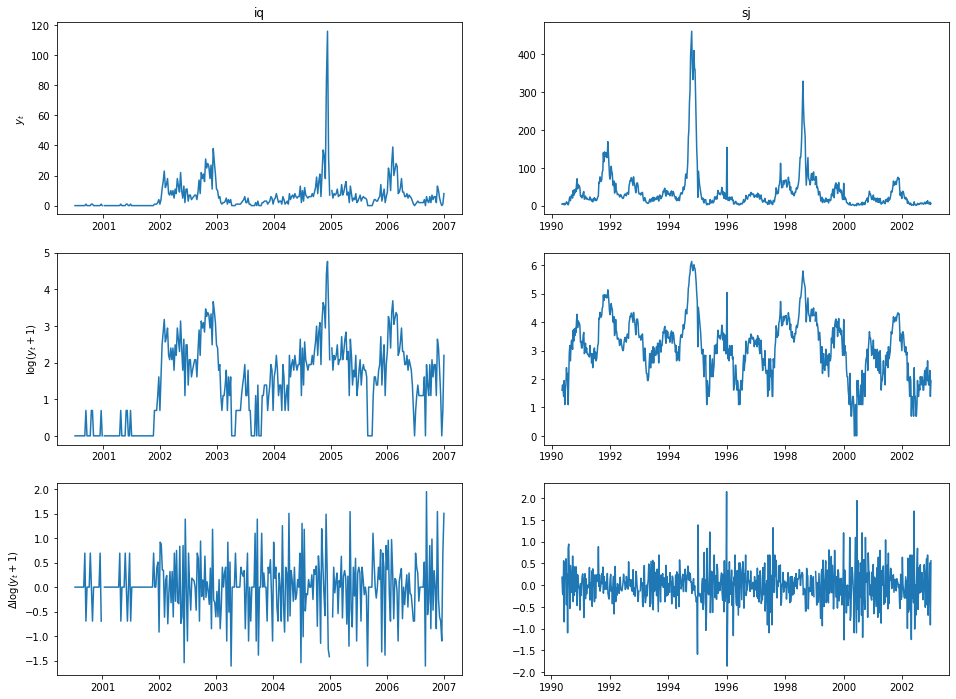

In [6]:
plot_data = y1.to_frame()
plot_data['log(y+1)'] = plot_data['total_cases'].apply(lambda x: np.log(x+1))
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 12))
c = 0
for city in plot_data.index.get_level_values('city').unique():
    t = plot_data.loc[city].index.get_level_values('week_start_date')
    ax[0][c].plot(t, plot_data.loc[city]['total_cases'])
    if c == 0:
        ax[0][c].set_ylabel('$y_t$')
    ax[1][c].plot(t, plot_data.loc[city]['log(y+1)'])
    if c == 0:
        ax[1][c].set_ylabel('$\\log(y_t+1)$')
    ax[2][c].plot(t, plot_data.loc[city]['log(y+1)'].diff())
    if c == 0:
        ax[2][c].set_ylabel('$\\Delta\\log(y_t+1)$')
    ax[0][c].set_title(city)
    c += 1
plt.show()


In [7]:
from src.d04_modeling.arx import ARX

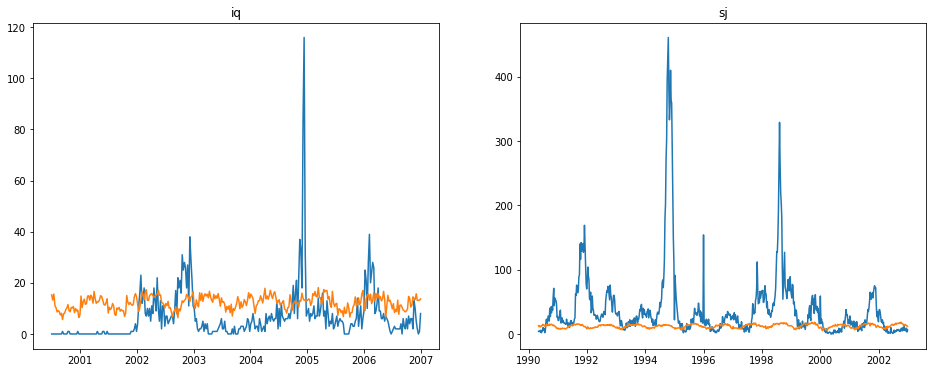

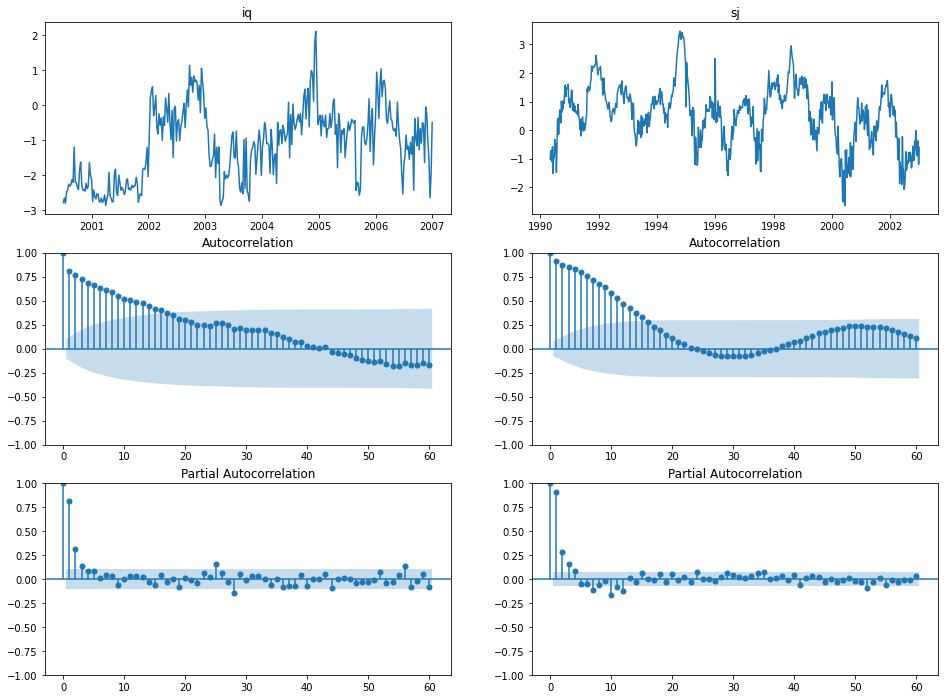

([9.750815432497959, 13.523942714337506], [183, 278])

In [8]:
ols_model = ARX(x_train=z1, y_train=y1, p=None)
ols_model.fit()
ols_model.plot_prediction(z1, y1)
ols_model.analyze_residuals(z1, y1)
ols_model.get_mae(z2, y2)

In [9]:
res_ols = ols_model.get_model_results(city)
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_cases   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     8.749
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           9.91e-06
Time:                        22:05:10   Log-Likelihood:                -1691.8
No. Observations:                1001   AIC:                             3392.
Df Residuals:                     997   BIC:                             3411.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x0             0.0845      0.017      5.021      0.000       0.051       0.117
x1            -0.0024      0.018     -0.137      0.891      -0.037       0.032
x2             0.0261      0.022      1.181      0.238      -0.017       0.070
const          2.5677      0.042     61.813      0.000       2.486       2.649
==============================================================================
Omnibus:                       16.135   Durbin-Watson:                   0.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.392
Skew:                          -0.178   Prob(JB):                      0.00204
Kurtosis:                       2.587   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ARIX

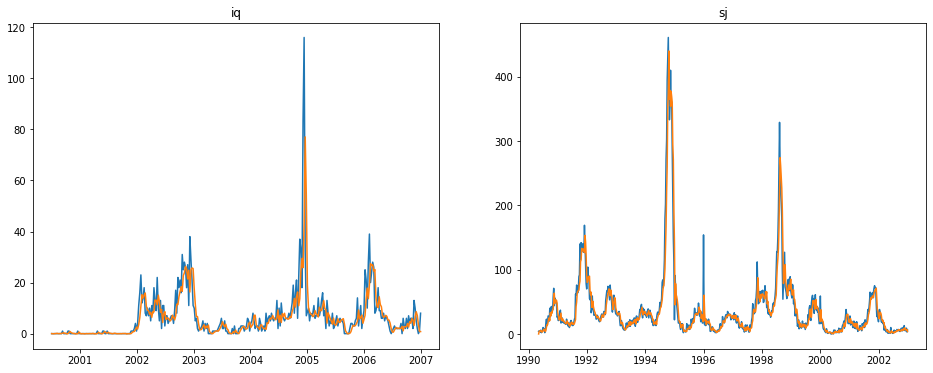

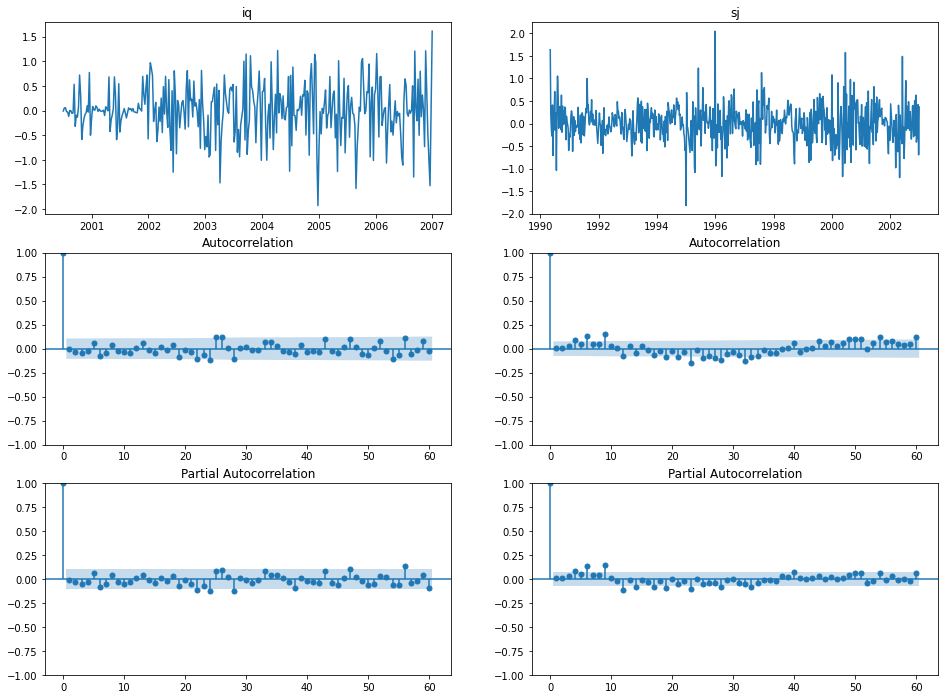

,AIC,AICc,BIC
iq,549.820714,550.159082,576.602715
sj,650.845097,651.066295,686.783015


In [10]:
arx_model = ARX(x_train=z1, y_train=y1, p={'iq': 2, 'sj': 3}, d=1)
arx_model.fit()
arx_model.plot_prediction(z1, y1)
arx_model.analyze_residuals(z1, y1)
arx_model.get_mae(z2, y2)
arx_model.insample_model_evaluation()

In [11]:
res_arx = arx_model.get_model_results(city)
res_arx.params

x0        1.883977e-02
x1       -1.330338e-02
x2       -3.076060e-04
const     1.448104e-11
ar.L1    -4.065831e-01
ar.L2    -2.242900e-01
ar.L3    -9.824589e-02
sigma2    1.531497e-01
dtype: float64

### Prediction Error

In [12]:
arx_model._last_obs_t

{'iq': Timestamp('2006-12-31 00:00:00', freq='W-SUN'),
 'sj': Timestamp('2002-12-29 00:00:00', freq='W-SUN')}

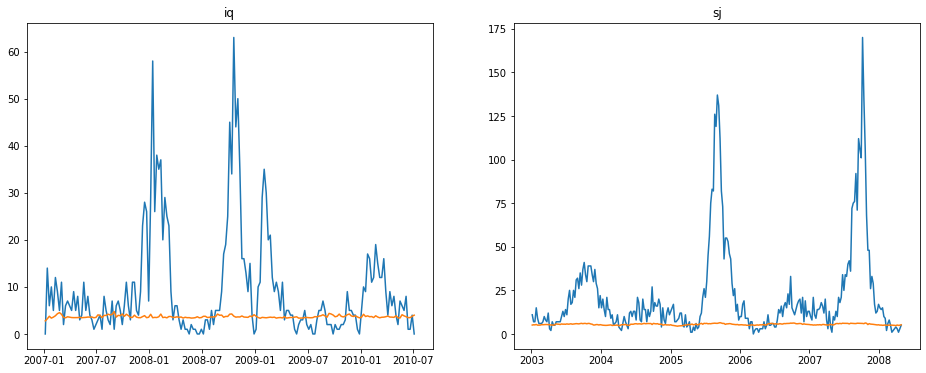

([7.1026584610140855, 16.773504757342632], [183, 278])

In [13]:
arx_model.fit()
arx_model.plot_prediction(z2, y2)
arx_model.get_mae(z2, y2)

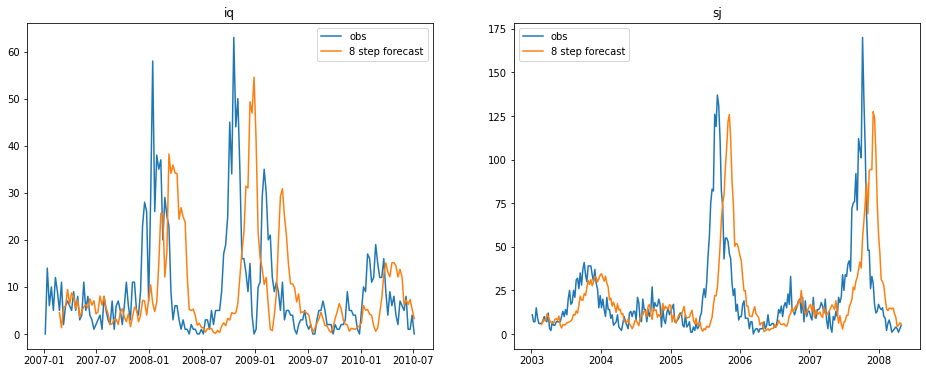

In [14]:
arx_model.plot_forecast(z2, y2)

In [15]:
arx_model.get_mae(z2, y2, m=8)

([9.454577927294379, 16.409383589520747], [183, 278])

# Do the factors contribute information

- Using information to determine factors
- Do the factors contribute information to the observations

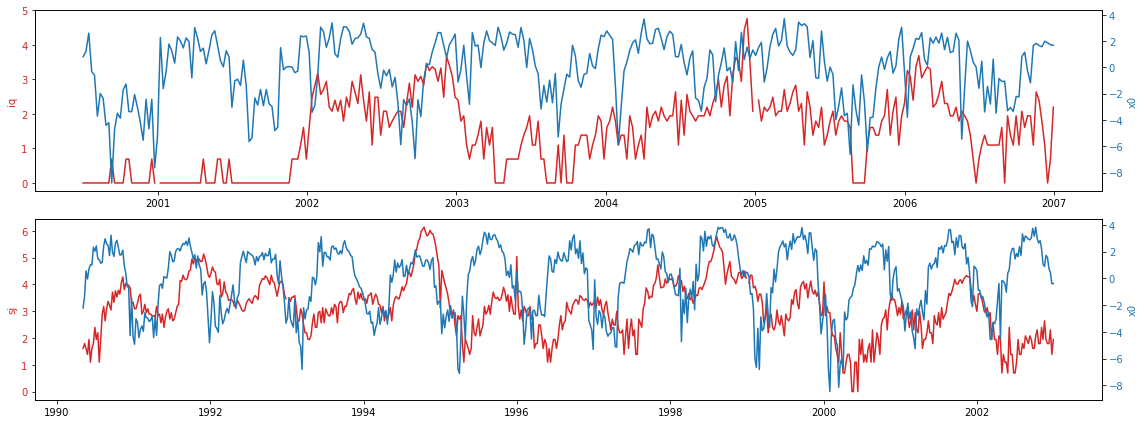

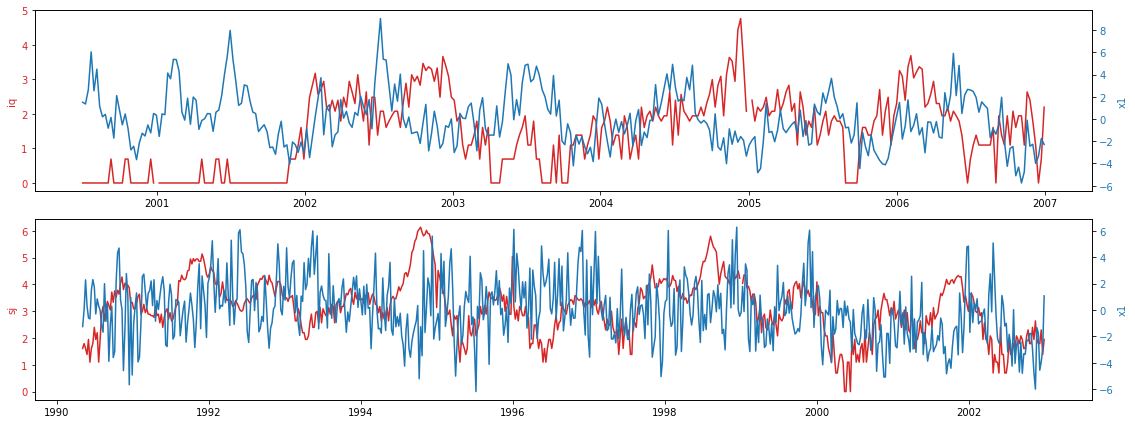

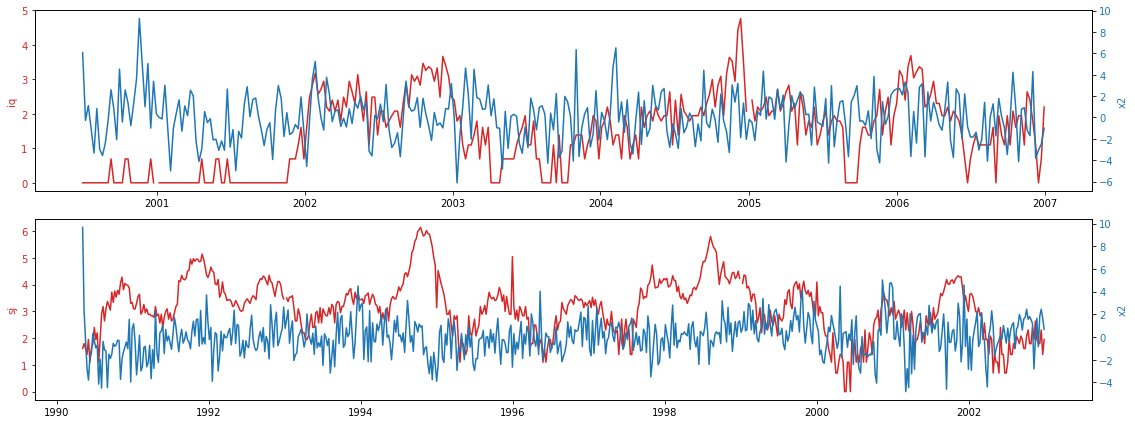

In [16]:
z = z1
y = y1
for col in z.columns[:-1]:
    fig, ax1 = plt.subplots(nrows=2, figsize=(16, 6))
    c = 0 
    for city in z.index.get_level_values('city').unique():
        t=y.loc[city].index.get_level_values('week_start_date')
        color = 'tab:red'
        ax1[c].set_ylabel(city, color=color)
        ax1[c].plot(t, np.log(y.loc[city]+1), color=color)
        ax1[c].tick_params(axis='y', labelcolor=color)

        ax2 = ax1[c].twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel(col, color=color)
        ax2.plot(t, z[col].loc[city], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        c += 1
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

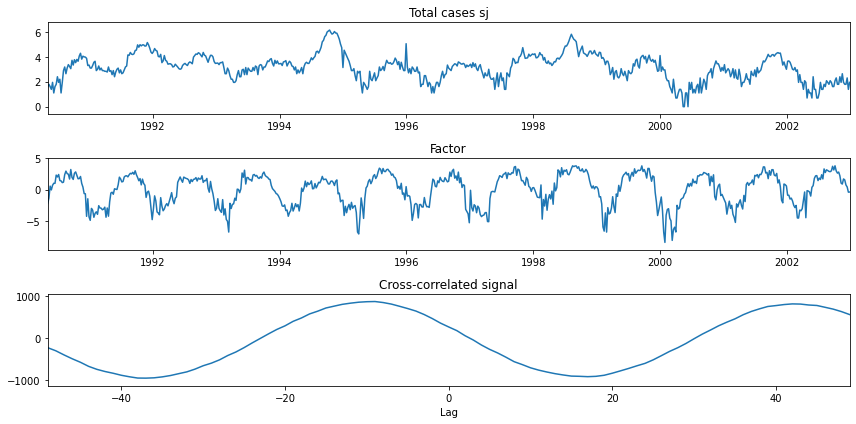

In [17]:
from scipy import signal
col = z.columns[0]
sig2 = z[col].loc[city]
sig1 = np.log(y.loc[city]+1).interpolate()
t = y.loc[city].index.get_level_values('week_start_date')
corr = signal.correlate(sig2, sig1)
lags = signal.correlation_lags(len(sig1), len(sig1))

fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(12, 6))
ax_orig.plot(t, sig1)
ax_orig.set_title('Total cases %s' % city)
ax_noise.plot(t, sig2)
ax_noise.set_title('Factor')
mask = np.abs(lags) < 50
ax_corr.plot(lags[mask], corr[mask])
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [18]:
np.isnan(sig2).any()

False